# Contexto

El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerias

In [1]:
import pandas as pd
import numpy as np
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn import metrics

from geopy.distance import geodesic

import warnings
warnings.filterwarnings("ignore")

# Carga del Dataset

In [2]:
## Carga datos de dataset en dataframe
file_path= 'https://raw.githubusercontent.com/guillericci/AA1-TUIA-2025C1-Aranda-Cicoria-Ricci/refs/heads/main/uber_fares.csv'

df = pd.read_csv(file_path)

# Analisis Exploratorio

Procedemos a obtener información general del dataset. Variables involucradas, cantidad de registros no nulos y tipos de datos de las mismas.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


De la información extraída podemos observar que falta el registro de una ubicación de destino. Tendremos que analizar cómo considerarla. Lo haremos más adelante, luego de analizar más variables.

Procedemos a obtener algunos de los datos de nuestro dataset para visualizar su estructura.

In [4]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


Ahora, visualizaremos de forma general la principales medidas descriptivas de las variables cuantitativas a considerar.

In [5]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


### Limpieza

De la visualización de las medidas descriptivas generales vemos que hay valores inconsistentes en nuentra variable target (menores a cero). Tenemos que eliminar los registros referentes a estos valores.


In [6]:
df = df[df['fare_amount'] > 0]

Analizamos los valores de la variable relativa a la cantidad de pasajeros.

In [7]:
print(df['passenger_count'].value_counts())

passenger_count
1      138414
2       29424
5       14005
3        8878
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64


Tomaremos el criterio de que un viaje puede tener hasta 10 pasajeros. Notamos que hay un solo valor atípico para esta consideración. Debido a la magnitud del dataset, decidimos eliminar este registro.

In [8]:
df = df[df['passenger_count'] < 10]

Nos centraremos ahora en las variables referidas a la ubicación de los viajes, analizaremos la distribución de las mismas y su variabilidad

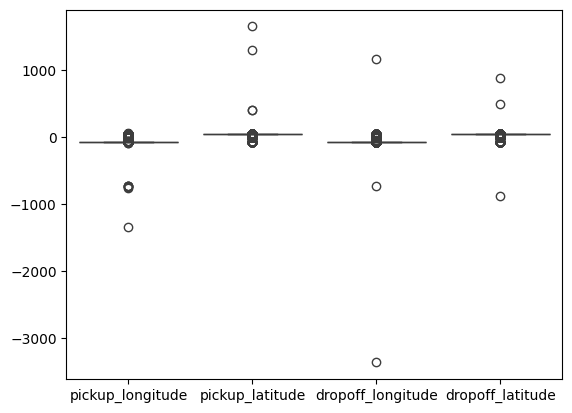

In [9]:
ubicacion = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
sns.boxplot(data=df[ubicacion])
plt.show()

A partir del gráfico presentado, notamos la presencia de ciertos valores extremos que podrían distorsionar los datos de nuestro modelo.

Procedemos también a graficar los pares de valores tanto de salida cómo de llegada para visualizar su comportamiento.

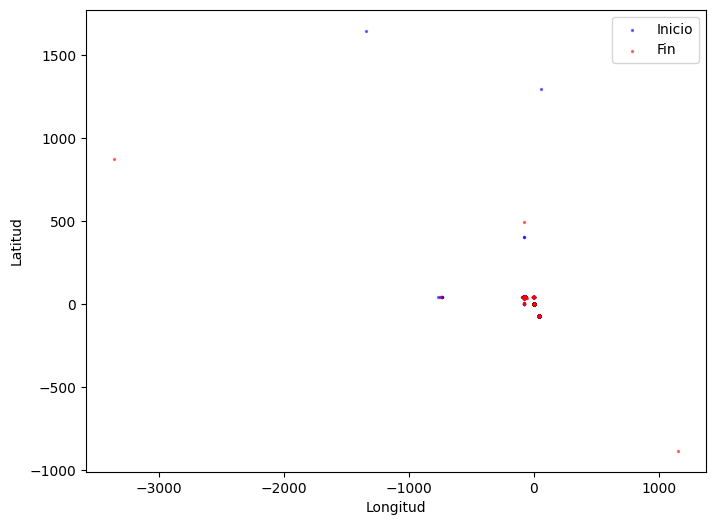

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], color='blue', s=2, alpha=0.5, label='Inicio')
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], color='red', s=2, alpha=0.5, label='Fin')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.show()

Si bien esta representación plana no es del todo precisa por la naturaleza de las componentes geográficas, podemos visualizar también de este modo, la concentración de puntos en un área y algunos puntos bastante alejados.

Sabemos que el dataset cuenta con registros de la ciudad de Nueva York, por lo cuál tomaremos la decisión de incluir los puntos de viajes que estén dentro de los rangos de valores para esta ciudad. De esta manera descartamos los valores extremos, asumiendo que ***nuestro modelo sólo tendrá validez dentro del rango considerado***.

In [11]:
df_limpio = df[(df['pickup_longitude'] <= -73.7004 ) & (df['pickup_longitude'] >= -74.2591)]
df_limpio = df_limpio[(df_limpio['pickup_latitude'] <= 40.9176 ) & (df_limpio['pickup_latitude'] >= 40.4774)]
df_limpio = df_limpio[(df_limpio['dropoff_longitude'] <= -73.7004 ) & (df_limpio['dropoff_longitude'] >= -74.2591)]
df_limpio = df_limpio[(df_limpio['dropoff_latitude'] <= 40.9176 ) & (df_limpio['dropoff_latitude'] >= 40.4774)]

Volvemos a graficar los puntos resultantes.

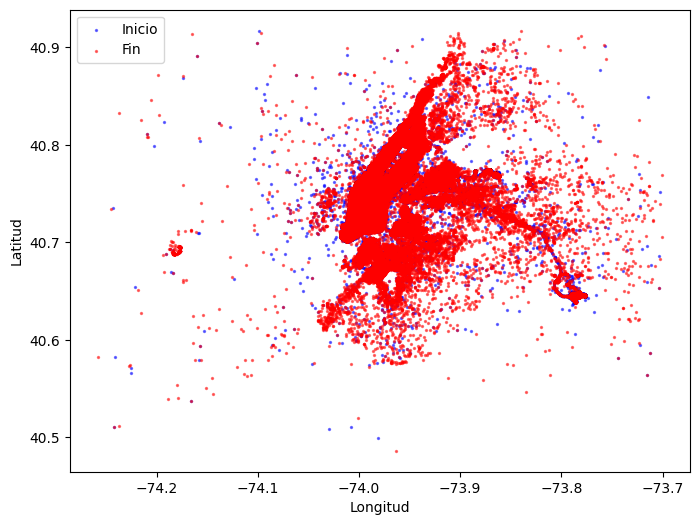

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df_limpio['pickup_longitude'], df_limpio['pickup_latitude'], color='blue', s=2, alpha=0.5, label='Inicio')
plt.scatter(df_limpio['dropoff_longitude'], df_limpio['dropoff_latitude'], color='red', s=2, alpha=0.5, label='Fin')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.show()

Y para una visualización más precisa los plasmamos en el mapa de la ciudad.

In [13]:
"""
import folium

# Crear el mapa centrado en Nueva York
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Filtrar filas con valores nulos o coordenadas inválidas
df_valid = df_limpio[
    df_limpio[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].notnull().all(axis=1)
]

# Filtrar coordenadas dentro del rango válido
df_valid = df_valid[
    (df_valid['pickup_latitude'].between(-90, 90)) &
    (df_valid['pickup_longitude'].between(-180, 180)) &
    (df_valid['dropoff_latitude'].between(-90, 90)) &
    (df_valid['dropoff_longitude'].between(-180, 180))
]

# Agregar puntos de recogida y destino en un solo bucle
for _, row in df_valid.iterrows():
    # Punto de recogida (azul)
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5
    ).add_to(m)

    # Punto de destino (rojo)
    folium.CircleMarker(
        location=[row['dropoff_latitude'], row['dropoff_longitude']],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5
    ).add_to(m)

# Mostrar el mapa
m
"""

"\nimport folium\n\n# Crear el mapa centrado en Nueva York\nm = folium.Map(location=[40.7128, -74.0060], zoom_start=12)\n\n# Filtrar filas con valores nulos o coordenadas inválidas\ndf_valid = df_limpio[\n    df_limpio[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].notnull().all(axis=1)\n]\n\n# Filtrar coordenadas dentro del rango válido\ndf_valid = df_valid[\n    (df_valid['pickup_latitude'].between(-90, 90)) &\n    (df_valid['pickup_longitude'].between(-180, 180)) &\n    (df_valid['dropoff_latitude'].between(-90, 90)) &\n    (df_valid['dropoff_longitude'].between(-180, 180))\n]\n\n# Agregar puntos de recogida y destino en un solo bucle\nfor _, row in df_valid.iterrows():\n    # Punto de recogida (azul)\n    folium.CircleMarker(\n        location=[row['pickup_latitude'], row['pickup_longitude']],\n        radius=2,\n        color='blue',\n        fill=True,\n        fill_color='blue',\n        fill_opacity=0.5\n    ).add_to(m)\n\n    # Punto de desti

A continuacion agregaremos algunas variables al dataset. Tomamos la desición de hacerlo antes de la división de datos teniendo en cuenta que las mismas no modificarán el entrenamiento del modelo, ya que no se basan en valores de la variable target ni en medidas calculadas sobre el dataset completo.

Creamos la variable "distancia" calculada a partir de los datos de latitud y longitud de partida y llegada.

In [14]:
df_limpio['distancia']=df_limpio.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).kilometers, axis=1)

Vamos a analizar si el costo varía según la cantidad de pasajeros.

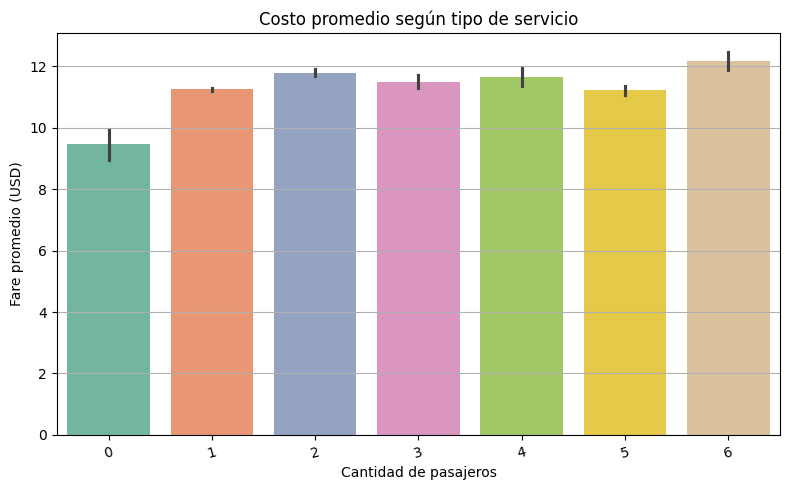

In [15]:
# Costo promedio por cantidad de pasajeros
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='passenger_count', y='fare_amount', estimator='mean', palette='Set2')
plt.title('Costo promedio según tipo de servicio')
plt.ylabel('Fare promedio (USD)')
plt.xlabel('Cantidad de pasajeros')
plt.xticks(rotation=15)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

En base a la información del gráfico decidimos segmentar la variable "cantidad de pasajeros" para considerar 3 tipos de categorías según el tipo de viaje realizado y en función del vehículo a cargo.

In [16]:
df_limpio['encomienda'] = (df_limpio['passenger_count'] == 0).astype(int)
df_limpio['auto/moto'] = df_limpio['passenger_count'].between(1, 4).astype(int)
# Eliminamos 'passenger_count'
df_limpio=df_limpio.drop('passenger_count', axis=1)

Separamos la variable 'pickup_datetime' referida a la fecha y hora de inicio del viaje en sus componentes y además creamos nuevas variables para determinar si el viaje corresponde a un día de semana, fin de semana o feriado.

In [17]:
df_limpio['pickup_datetime'] = pd.to_datetime(df_limpio['pickup_datetime'], utc=True)

#Extraemos de 'pickup_datetime' el día del mes, el día de la semana, el mes y el año.
df_limpio['hora'] = df_limpio['pickup_datetime'].dt.hour
df_limpio['dia_semana'] = df_limpio['pickup_datetime'].dt.day_name()
df_limpio['mes'] = df_limpio['pickup_datetime'].dt.month
df_limpio['anio'] = df_limpio['pickup_datetime'].dt.year
df_limpio['fecha'] = df_limpio['pickup_datetime'].dt.date
df_limpio['numero_dia'] = df_limpio['pickup_datetime'].dt.day

#Creamos las variables referidas al "tipo de día"
us_holidays = holidays.US()
df_limpio['es_feriado'] = df_limpio['fecha'].apply(lambda x: x in us_holidays)


A continuación, presentamos visualizaciones que buscan reflejar la relación entre el costo promedio del viaje y distintas variables temporales (hora, día de la semana, mes, año) y espaciales (distancia). Estos gráficos permiten identificar patrones y tendencias que orienten a la selección de variables para el modelo predictivo.
Si bien utilizamos el dataset completo (es decir tambien estamos graficando datos de test que no sería ideal), lo hacemos con el objetivo de visualización para entender en primera medida el comportamiento general. No afectamos de esta manera ningún calculo de medidas o parametros futuros que puedan distorsionar el modelo.

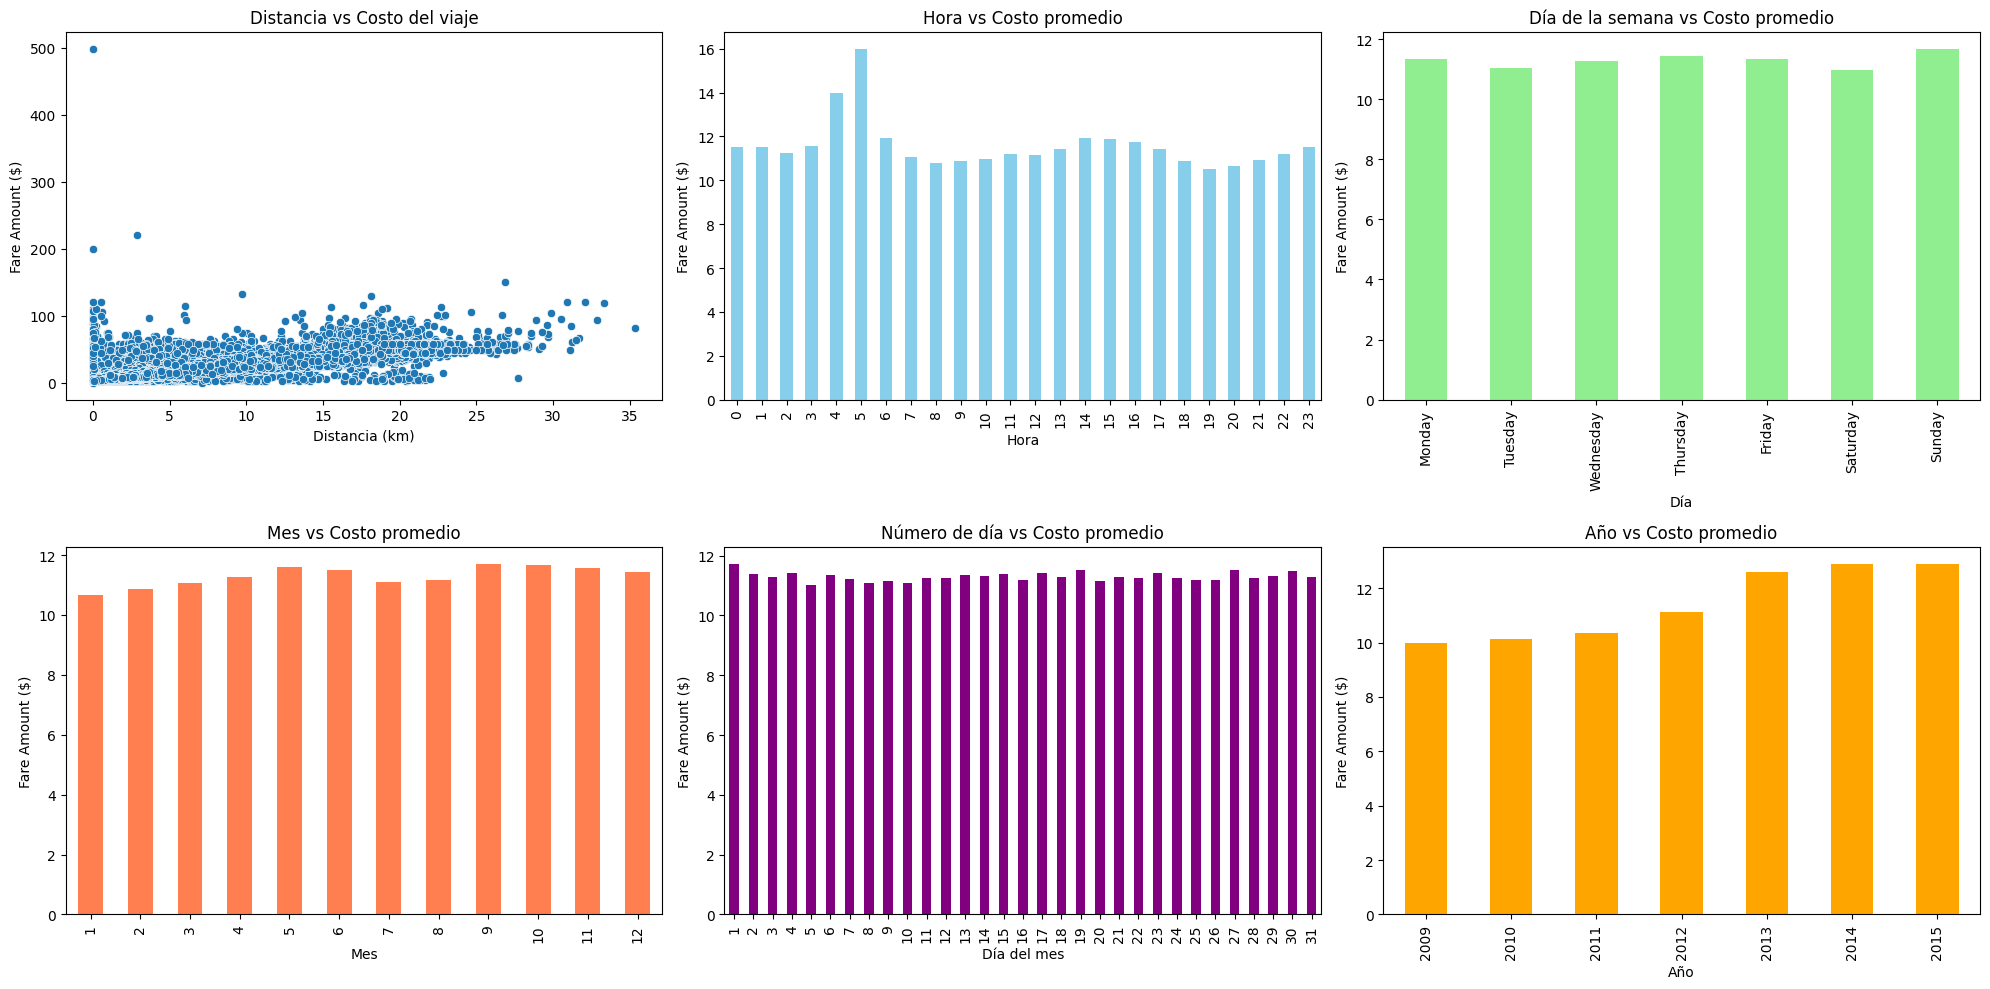

In [18]:
# Crear una figura con 6 subplots (en 2 filas de 3 columnas)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()  # Para acceder a los ejes como una lista simple

# 1. Scatterplot: Distancia vs Costo
sns.scatterplot(data=df_limpio, x='distancia', y='fare_amount', ax=axes[0])
axes[0].set_title('Distancia vs Costo del viaje')
axes[0].set_xlabel('Distancia (km)')
axes[0].set_ylabel('Fare Amount ($)')

# 2. Costo promedio según hora
df_limpio.groupby('hora')['fare_amount'].mean().plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Hora vs Costo promedio')
axes[1].set_xlabel('Hora')
axes[1].set_ylabel('Fare Amount ($)')

# 3. Costo promedio según día de la semana
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_limpio.groupby('dia_semana')['fare_amount'].mean().reindex(orden_dias).plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Día de la semana vs Costo promedio')
axes[2].set_xlabel('Día')
axes[2].set_ylabel('Fare Amount ($)')

# 4. Costo promedio según mes
df_limpio.groupby('mes')['fare_amount'].mean().plot(kind='bar', ax=axes[3], color='coral')
axes[3].set_title('Mes vs Costo promedio')
axes[3].set_xlabel('Mes')
axes[3].set_ylabel('Fare Amount ($)')

# 5. Costo promedio según número del día del mes
df_limpio.groupby('numero_dia')['fare_amount'].mean().plot(kind='bar', ax=axes[4], color='purple')
axes[4].set_title('Número de día vs Costo promedio')
axes[4].set_xlabel('Día del mes')
axes[4].set_ylabel('Fare Amount ($)')

# 6. Costo promedio según año
df_limpio.groupby('anio')['fare_amount'].mean().plot(kind='bar', ax=axes[5], color='orange')
axes[5].set_title('Año vs Costo promedio')
axes[5].set_xlabel('Año')
axes[5].set_ylabel('Fare Amount ($)')

# Ajuste final
plt.tight_layout()
plt.show()


El siguiente gráfico representa el costo promedio según la hora del día y el día de la semana para observar si varía el comportamiento cuando es fin de semana respecto a los días de semana.


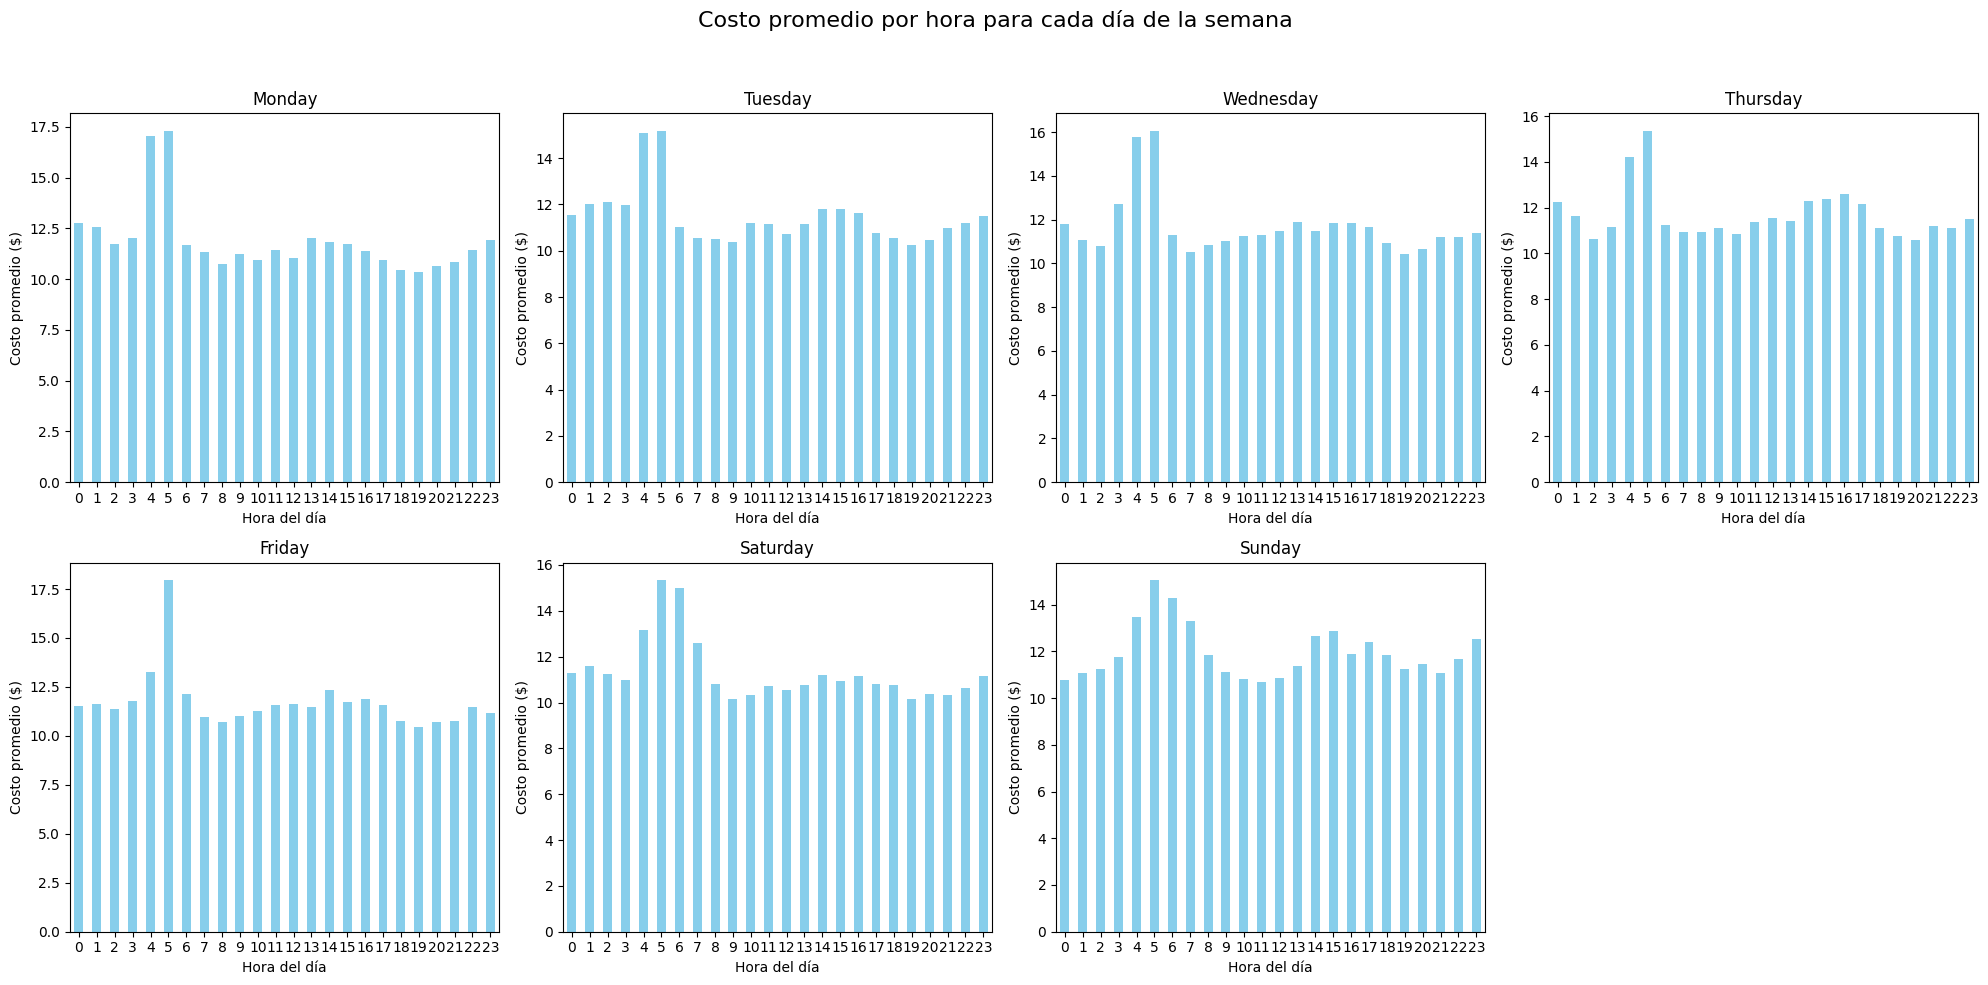

In [19]:
# Orden correcto de los días
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Crear figura con 7 subplots (2 filas, 4 columnas para que entren bien)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Filtrar y graficar por cada día
for i, dia in enumerate(orden_dias):
    data_dia = df_limpio[df_limpio['dia_semana'] == dia]
    promedio_hora = data_dia.groupby('hora')['fare_amount'].mean()
    promedio_hora.plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'{dia}')
    axes[i].set_xlabel('Hora del día')
    axes[i].set_ylabel('Costo promedio ($)')
    axes[i].set_xticks(range(0, 24))
    axes[i].set_xticklabels(range(0, 24), rotation=0)

# Eliminar el subplot vacío (posición 7 en índice, el 8vo gráfico)
fig.delaxes(axes[7])

plt.suptitle('Costo promedio por hora para cada día de la semana', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


El siguiente gráfico compara el costo promedio por hora entre días de semana y fines de semana, con el objetivo de evaluar si esta agrupación captura diferencias significativas que justifiquen la creación de una nueva variable categórica es_finde.

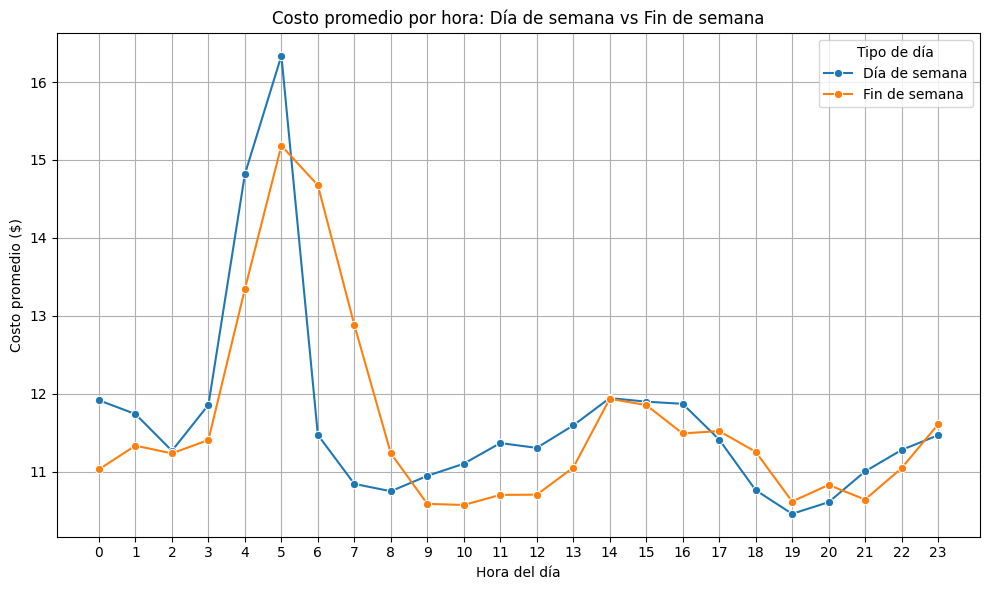

In [20]:
#creamos la varible es_finde
df_limpio['es_finde'] = df_limpio['pickup_datetime'].dt.dayofweek >= 5  # Sábado (5) y domingo (6)

# Agrupamos por es_finde y hora, calculando el costo promedio
promedio_finde = df_limpio.groupby(['es_finde', 'hora'])['fare_amount'].mean().reset_index()

# Cambiamos True/False por texto más claro
promedio_finde['es_finde'] = promedio_finde['es_finde'].map({True: 'Fin de semana', False: 'Día de semana'})

# Gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=promedio_finde, x='hora', y='fare_amount', hue='es_finde', marker='o')
plt.title('Costo promedio por hora: Día de semana vs Fin de semana')
plt.xlabel('Hora del día')
plt.ylabel('Costo promedio ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Tipo de día')
plt.tight_layout()
plt.show()


## Selección variables predictoras

Para la construcción del modelo de regresión se seleccionaron variables que presentan relación con el costo del viaje. Se incluyó la distancia del viaje (en km), dado que muestra una fuerte correlación con el costo, así como variables temporales como la hora del día, si es fin de semana, si es feriado y el mes del año, las cuales reflejan patrones horarios, semanales y estacionales que influyen en el precio. Se descartó la variable "Año", ya que no resulta útil en escenarios de predicción futura y podría comprometer la capacidad de generalización del modelo.

In [21]:
# Codificación cíclica para hora
df_limpio['hora_sin'] = np.sin(2 * np.pi * df_limpio['hora'] / 24)
df_limpio['hora_cos'] = np.cos(2 * np.pi * df_limpio['hora'] / 24)

# Codificación cíclica para mes
df_limpio['mes_sin'] = np.sin(2 * np.pi * df_limpio['mes'] / 12)
df_limpio['mes_cos'] = np.cos(2 * np.pi * df_limpio['mes'] / 12)


# Eliminacion de variables originales:
df_limpio.drop(['key','date','pickup_datetime','dropoff_longitude','dropoff_latitude','hora', 'dia_semana', 'numero_dia', 'mes', 'anio', 'fecha'], axis=1, inplace=True)

In [22]:
df_limpio.head()

,fare_amount,pickup_longitude,pickup_latitude,distancia,encomienda,auto/moto,es_feriado,es_finde,hora_sin,hora_cos,mes_sin,mes_cos
0,7.5,-73.999817,40.738354,1.681111,0,1,False,False,-0.965926,0.258819,5.000000e-01,-0.866025
1,7.7,-73.994355,40.728225,2.454363,0,1,False,False,-0.866025,0.500000,-5.000000e-01,-0.866025
2,12.9,-74.005043,40.740770,5.039603,0,1,False,False,-0.707107,0.707107,-8.660254e-01,-0.500000
3,5.3,-73.976124,40.790844,1.661442,0,1,False,False,0.866025,-0.500000,1.224647e-16,-1.000000
4,16.0,-73.925023,40.744085,4.483730,0,0,False,False,-0.965926,-0.258819,-8.660254e-01,-0.500000


# División de datos

Procedemos a dividir el dataset en conjunto de entrenamiento y prueba.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_limpio.drop(columns='fare_amount'), df_limpio['fare_amount'], test_size=0.2, random_state=42)

Realizamos un Correlograma para obvservar la correlación de las variables explicativas que consideraremos para le entrenamiento.

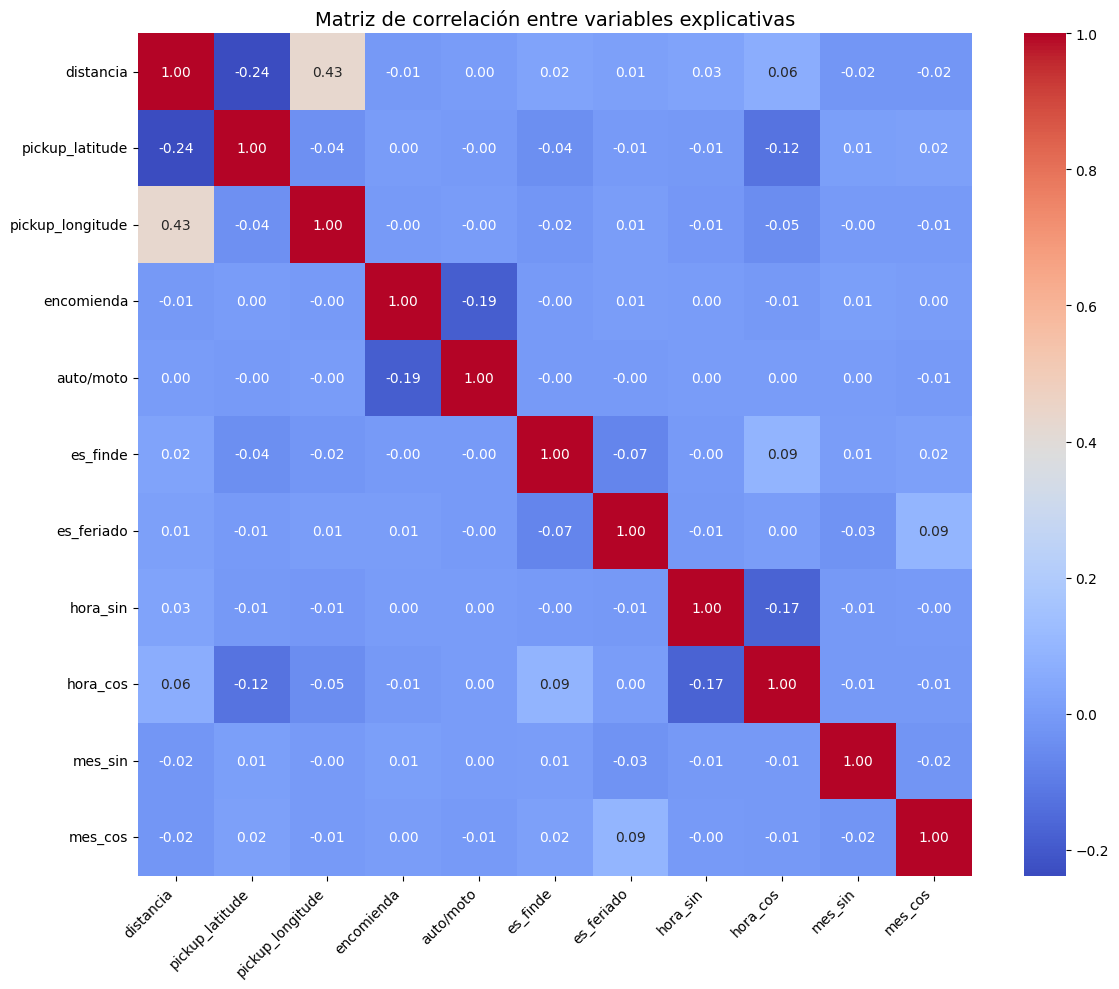

In [24]:
matriz = X_train[['distancia','pickup_latitude','pickup_longitude','encomienda', 'auto/moto', 'es_finde', 'es_feriado', 'hora_sin','hora_cos', 'mes_sin', 'mes_cos']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(matriz, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Matriz de correlación entre variables explicativas', fontsize=14)
plt.tight_layout()
plt.show()

# Preprocesamiento

## Imputación

Analizaremos nuevamente el comportamiento de la distancia en relación a la variable target.

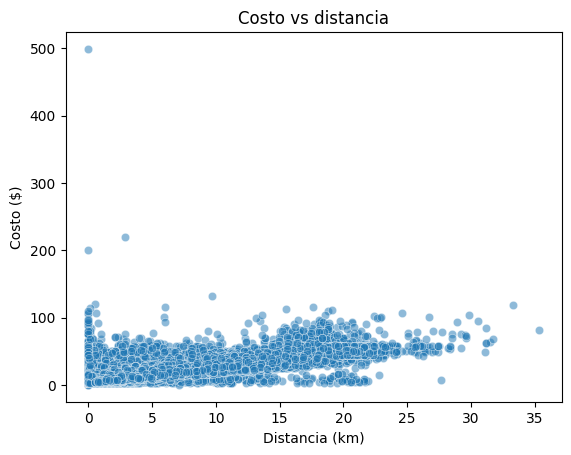

In [25]:
ax = sns.scatterplot(x=X_train['distancia'], y=y_train, alpha=0.5)
ax.set_title("Costo vs distancia")
ax.set_xlabel("Distancia (km)")
ax.set_ylabel("Costo ($)")
plt.show()

Vemos gran cantidad de registros con distancia cero y costo del viaje distinto de cero. Analizaremos cuántos son los registros que existen con esta condición.

In [26]:
condicion = (X_train['distancia'] == 0) & (y_train.loc[X_train.index] > 0)
inconsistentes = X_train[condicion]
print(f'Registros con distancia 0 y fare_amount > 0: {len(inconsistentes)}')

Registros con distancia 0 y fare_amount > 0: 1573


Debemos imputar estas distancias eligiendo alguna estrategia. Para esto, analizaremos la distribucion de la variable distancia.

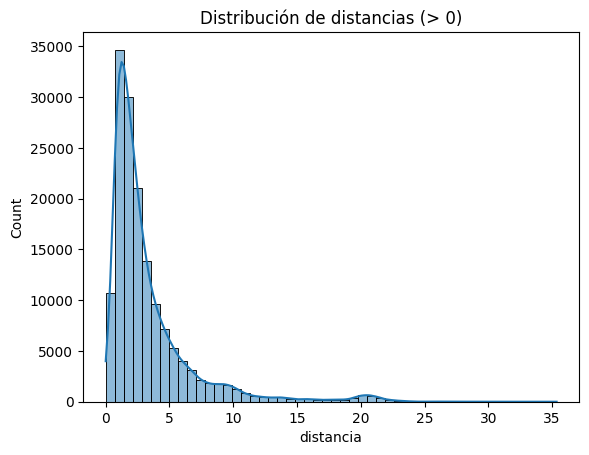

In [27]:
sns.histplot(X_train[X_train['distancia'] > 0]['distancia'], bins=50, kde=True)
plt.title("Distribución de distancias (> 0)")
plt.show()

Vemos que la distancia tiene una distribución sesgada a la derecha por lo que podríamos pensar en la mediana para imputar de mejor manera los datos.

Imputamos por la **mediana**. Probamos con otros métodos cómo imputar usando mediana por grupos de costo similar, pero tardaban mucho tiempo en relación a la precisión de salida que necesitabamos.

In [28]:
mediana_global = X_train[X_train['distancia'] > 0]['distancia'].median()
X_train.loc[X_train['distancia'] == 0, 'distancia'] = mediana_global

#Verifico que no hayan quedado distancias 0
print((X_train['distancia'] == 0).sum())

0


Analizamos adicionalmente la distribución de la variable target para poder entender visualmente su comportamiento.

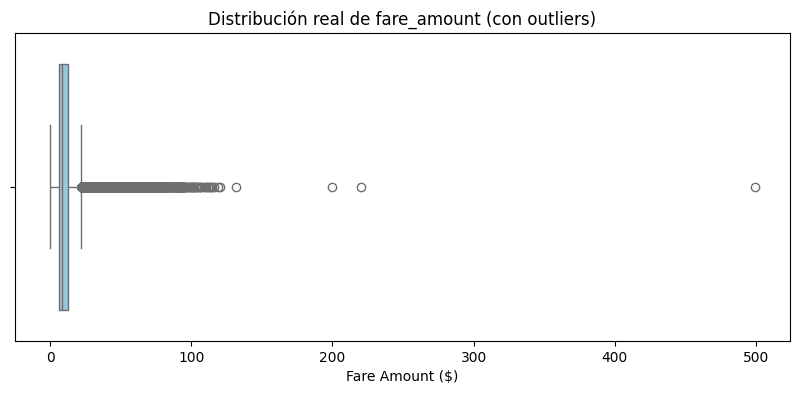

In [29]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=y_train, color='skyblue')
plt.title('Distribución real de fare_amount (con outliers)')
plt.xlabel('Fare Amount ($)')
plt.show()

A partir del gráfico vemos presencia de valores extremos (outliers) que distorsionan la escala y hacer dificil visualizar el resto de los datos. Procederemos a transformarlos en escala logarítmica.

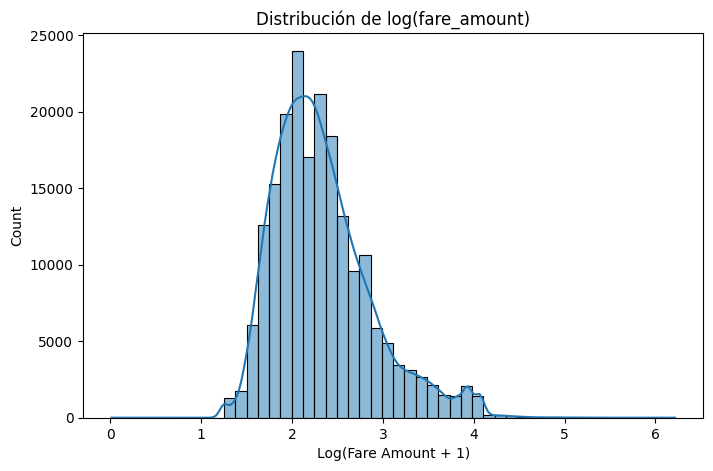

In [30]:
y_log = np.log1p(df['fare_amount'][df['fare_amount']> 0])

plt.figure(figsize=(8, 5))
sns.histplot(y_log, bins=50, kde=True)
plt.title('Distribución de log(fare_amount)')
plt.xlabel('Log(Fare Amount + 1)')
plt.show()

La variable target presenta una distribución sesgada a la derecha (asimetría positiva). Muchos valores bajos y pocos valores muy altos.

In [31]:
X_train.head()

,pickup_longitude,pickup_latitude,distancia,encomienda,auto/moto,es_feriado,es_finde,hora_sin,hora_cos,mes_sin,mes_cos
148677,-74.006856,40.730325,0.574188,0,1,False,True,7.071068e-01,0.707107,-8.660254e-01,-5.000000e-01
82290,-74.003068,40.726852,1.520664,0,1,False,True,-2.588190e-01,-0.965926,1.000000e+00,6.123234e-17
160210,-73.990145,40.756322,1.064990,0,1,False,False,1.224647e-16,-1.000000,-2.449294e-16,1.000000e+00
63263,-73.986353,40.759360,1.319196,0,1,False,False,2.588190e-01,-0.965926,1.000000e+00,6.123234e-17
196993,-73.991280,40.745765,1.352891,0,1,False,False,8.660254e-01,-0.500000,-1.000000e+00,-1.836970e-16


In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156405 entries, 148677 to 124808
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pickup_longitude  156405 non-null  float64
 1   pickup_latitude   156405 non-null  float64
 2   distancia         156405 non-null  float64
 3   encomienda        156405 non-null  int64  
 4   auto/moto         156405 non-null  int64  
 5   es_feriado        156405 non-null  bool   
 6   es_finde          156405 non-null  bool   
 7   hora_sin          156405 non-null  float64
 8   hora_cos          156405 non-null  float64
 9   mes_sin           156405 non-null  float64
 10  mes_cos           156405 non-null  float64
dtypes: bool(2), float64(7), int64(2)
memory usage: 12.2 MB


In [33]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39102 entries, 42227 to 177287
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pickup_longitude  39102 non-null  float64
 1   pickup_latitude   39102 non-null  float64
 2   distancia         39102 non-null  float64
 3   encomienda        39102 non-null  int64  
 4   auto/moto         39102 non-null  int64  
 5   es_feriado        39102 non-null  bool   
 6   es_finde          39102 non-null  bool   
 7   hora_sin          39102 non-null  float64
 8   hora_cos          39102 non-null  float64
 9   mes_sin           39102 non-null  float64
 10  mes_cos           39102 non-null  float64
dtypes: bool(2), float64(7), int64(2)
memory usage: 3.1 MB


## Estandarizacion

Para el escalado de los datos utilizamos dos métodos que aplicaremos posteriormente para los distintos modelos.

In [34]:
# Escalado dentro de preprocesador

numericas = [
    'pickup_longitude', 'pickup_latitude', 'distancia',
    'hora_sin', 'hora_cos',
    'mes_sin', 'mes_cos']
otras = ['encomienda', 'auto/moto', 'es_finde', 'es_feriado']

preprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numericas)
], remainder='passthrough')  # Deja las columnas binarias sin tocar

In [35]:
# Creación de un nuevo X_train escalado

scaler = StandardScaler()
scaler.fit(X_train[numericas])

X_train_scaled = X_train.copy()
X_train_scaled[numericas] = scaler.transform(X_train[numericas])

X_test_scaled = X_test.copy()
X_test_scaled[numericas] = scaler.transform(X_test[numericas])

# Modelados

## Regresion Lineal

Creación del pipeline para el preprocesamiento y fitteo del modelo de regresión lineal.

In [36]:
pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', LinearRegression())
])

# Fitteo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'distancia', 'hora_sin',
                                                   'hora_cos', 'mes_sin',
                                                   'mes_cos'])])),
                ('modelo', LinearRegression())])

Predicciones.

In [37]:
y_pred_train = pipeline.predict(X_train)
print(y_pred_train.shape)
y_pred_train = y_pred_train.flatten()
y_pred_train[:10]

(156405,)


array([ 3.78365889,  7.33096495,  6.77782391,  7.10945941,  6.88883889,
       19.28285599,  4.35276676,  7.44541023,  9.94681464,  7.07573184])

In [38]:
y_pred_test = pipeline.predict(X_test)
print(y_pred_test.shape)
y_pred_test = y_pred_test.flatten()  
y_pred_test[:10]


(39102,)


array([ 5.66284693,  6.90392381, 10.84845215, 17.3795947 ,  7.53348426,
        8.79427168, 11.33276472, 13.23942021,  9.04259319,  6.06246368])

Analizamos los coeficientes obtenidos del modelo de regresión lineal y graficamos.

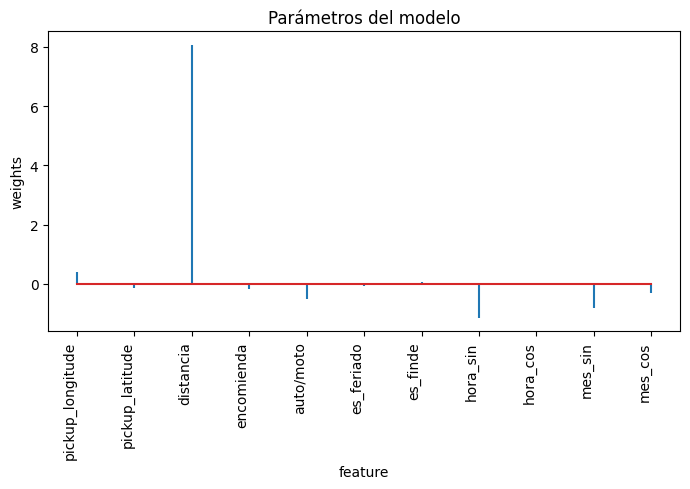

In [39]:
df_coeficientes = pd.DataFrame({
    'predictor': X_train.columns,
    'coef': pipeline.named_steps['modelo'].coef_.flatten()
})

fig, ax = plt.subplots(figsize=(7,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo')
plt.tight_layout()
plt.show()


Del gráfico obtenido podemos ver la gran influencia de la variable "distancia" sobre el modelo.

Error del modelo

In [40]:
def evaluar(y_true, y_pred, nombre):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Resultados para {nombre}:")
    print(f"  MSE: {mse:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²: {r2:.3f}\n")
    return mse, rmse, r2

# Evaluación en entrenamiento
mse_train, rmse_train, r2_train = evaluar(y_train, y_pred_train, 'Train')
mse_test, rmse_test, r2_test = evaluar(y_test, y_pred_test, 'Test')


Resultados para Train:
  MSE: 21.851
  RMSE: 4.674
  R²: 0.757

Resultados para Test:
  MSE: 21.365
  RMSE: 4.622
  R²: 0.769



El modelo lineal entrenado alcanza un desempeño sólido, con un R² de 0.757 en entrenamiento y 0.769 en testeo, lo que indica que es capaz de explicar aproximadamente el 76% de la variabilidad de las tarifas.
Además, la similitud entre los valores de RMSE en ambos conjuntos (4.67 en entrenamiento y 4.62 en test) sugiere que el modelo generaliza bien y no presenta signos de sobreajuste.
En promedio, el error absoluto es de unos $4.6.

Complementamos el análisis observando el gráfico de los residuos.

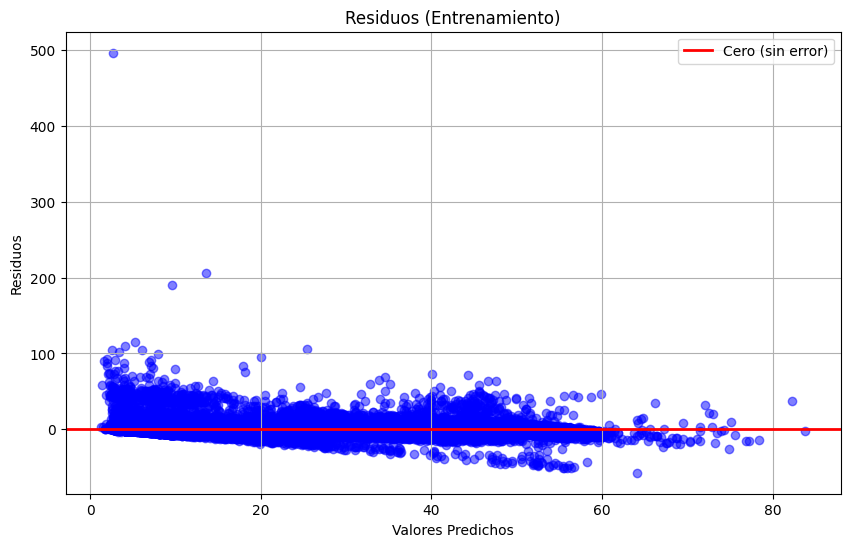

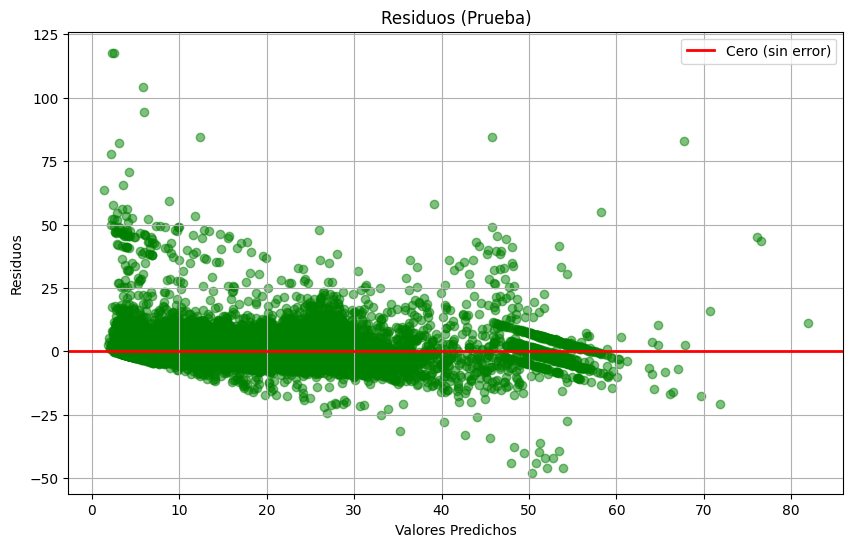

In [41]:
residuos_train = y_train - y_pred_train
residuos_test = y_test - y_pred_test


plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train, residuos_train, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', lw=2, label='Cero (sin error)')
plt.title('Residuos (Entrenamiento)')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuos_test, color='green', alpha=0.5)
plt.axhline(y=0, color='red', lw=2, label='Cero (sin error)')
plt.title('Residuos (Prueba)')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.legend()
plt.grid(True)
plt.show()


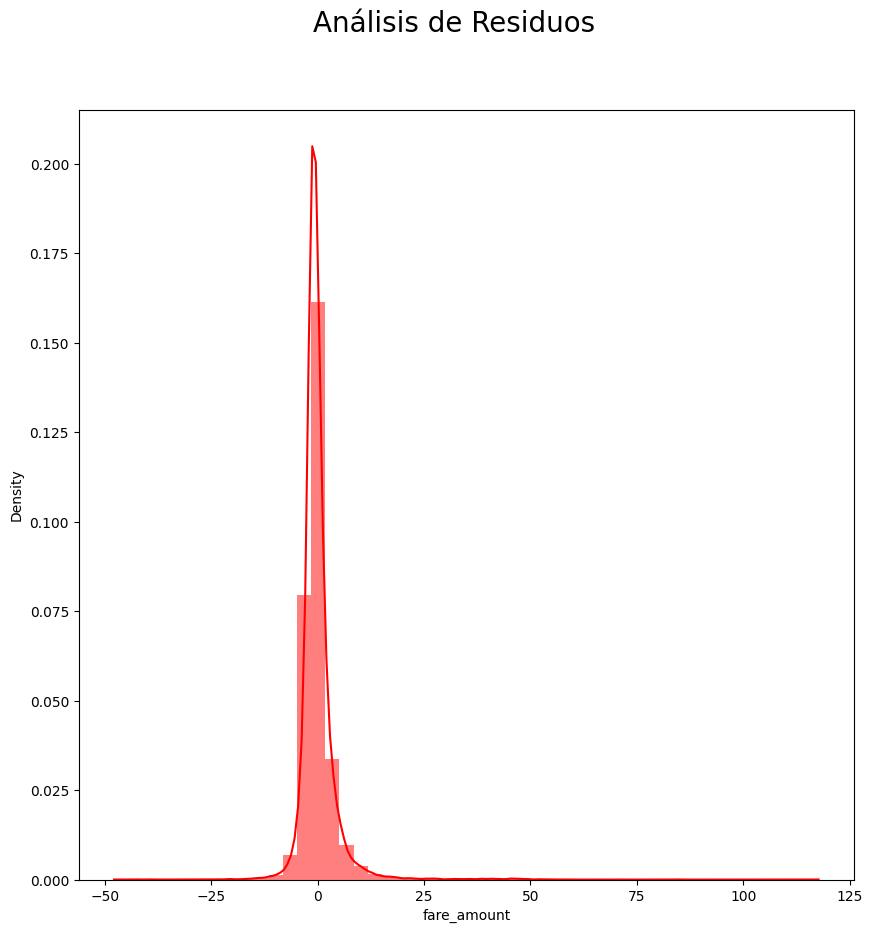

In [42]:
fig = plt.figure(figsize=(10,10))
sns.histplot((y_test - y_pred_test.reshape(y_test.shape)), color="red", kde=True, stat="density", linewidth=0,bins=50)
fig.suptitle('Análisis de Residuos', fontsize = 20)
plt.show()

Observamos a partir de los gráficos que la distribución de los errores es cercana a una distribución normal con media cero.

Procederemos a investigar algunos de los errores más significativas en las predicciones.

In [43]:
residuos = y_test - y_pred_test.reshape(y_test.shape)

df_residuos = pd.DataFrame({
    'real': y_test,
    'predicho': y_pred_test.reshape(y_test.shape),
    'residuo': residuos
})

df_completo = pd.concat([X_test.reset_index(drop=True), df_residuos.reset_index(drop=True)], axis=1)
df_outliers = df_completo.sort_values(by='residuo').head(5)

print("Top 5 outliers (errores más negativos):")
print(df_outliers)

Top 5 outliers (errores más negativos):
       pickup_longitude  pickup_latitude  distancia  encomienda  auto/moto  \
22650        -73.974401        40.793765  20.385748           0          1   
20833        -73.791050        40.645842  20.066718           0          0   
25116        -73.988653        40.721160  21.902057           0          1   
11922        -73.955633        40.772490  20.611726           0          1   
36333        -73.805040        40.650572  18.812636           0          0   

       es_feriado  es_finde  hora_sin      hora_cos  mes_sin       mes_cos  \
22650       False     False  0.500000 -8.660254e-01      0.5 -8.660254e-01   
20833       False     False -0.965926  2.588190e-01      1.0  6.123234e-17   
25116       False     False -1.000000 -1.836970e-16     -1.0 -1.836970e-16   
11922       False     False  0.965926 -2.588190e-01     -1.0 -1.836970e-16   
36333       False      True  0.000000  1.000000e+00      1.0  6.123234e-17   

       real   predicho

## Regularización

### Ridge


Creación del pipeline para el preprocesamiento y fitteo del modelo de Ridge.

In [44]:
pipe = Pipeline([
    ('preprocessing', preprocesador),
    ('modelo', RidgeCV(alphas=np.logspace(-6, 5, 200), store_cv_results=True))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'distancia', 'hora_sin',
                                                   'hora_cos', 'mes_sin',
                                                   'mes_cos'])])),
                ('modelo',
                 RidgeCV(alphas=array([1.00000000e-06, 1.13573336e-06, 1.28989026e-06, 1.46497140e-06,
       1.66381689e-06, 1.88965234e-06, 2.14614120e-06, 2.4...
       5.35356668e+03, 6.08022426e+03, 6.90551352e+03, 7.84282206e+03,
       8.90735464e+03, 1.01163798e+04, 1.14895100e+04, 1.30490198e+04,
       1.48202071e+04, 1.68318035e+04, 1.91164408e+04, 2.17111795e+04,
       2.46581108e+04, 2.80050389e+04, 3.18062569e+04, 3.61234270e+04,
       4.10265811e+04, 4.65952567e+04, 5.29197874e+04, 6.01027678e+04,
       6.82607183e+04, 7.75259749e+04, 8.80488358e+04, 1.00000000e+05]),
                         store_cv_results=True))])

In [45]:
pipe.named_steps['modelo'].alpha_

np.float64(10.473708979594509)

Evolución de los parámetros en función de alpha.

In [46]:
alphas = pipe.named_steps['modelo'].alphas
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.named_steps['ridge'].coef_.flatten())

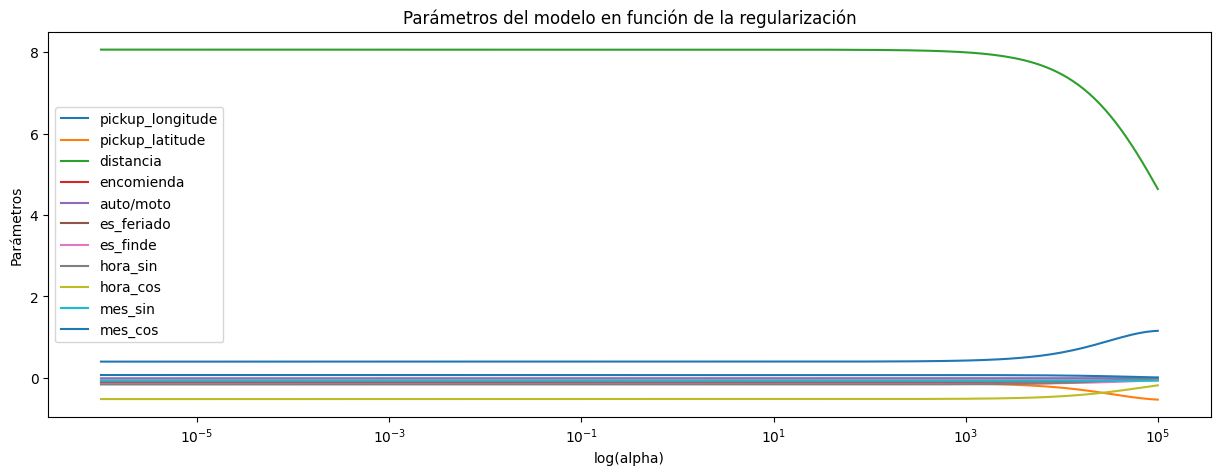

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

Evolución del error en función de la regularización.

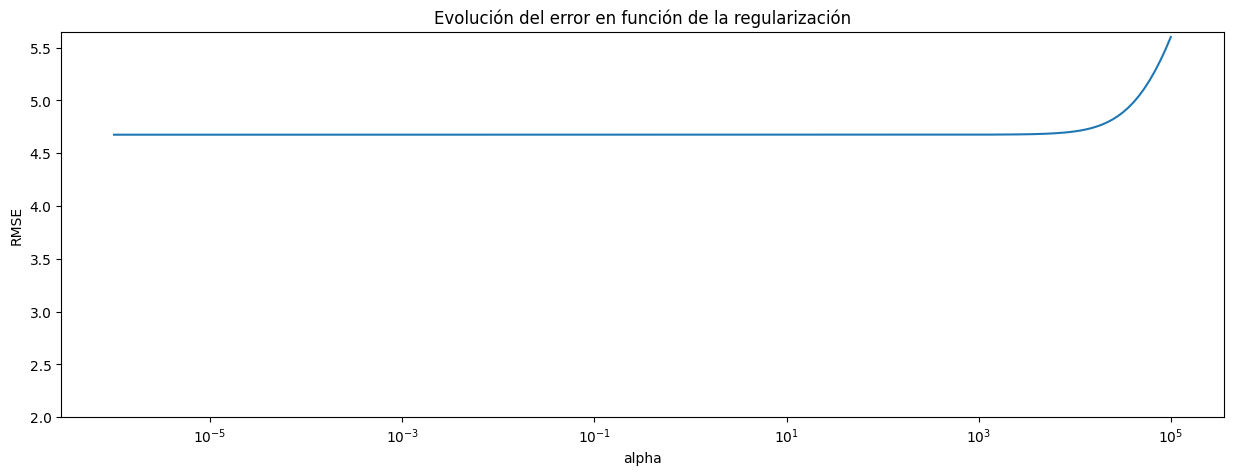

In [48]:
# Acceder al modelo RidgeCV dentro del pipeline
mod = pipe.named_steps['modelo']

# Calcular el MSE medio para cada valor de alpha
mse_cv = mod.cv_values_.mean(axis=0)

# Calcular el RMSE a partir del MSE
rmse_cv = np.sqrt(mse_cv)

# Identificar el valor óptimo de alpha y el RMSE mínimo
min_rmse = np.min(rmse_cv)
optimo = mod.alphas[np.argmin(rmse_cv)]

# Visualizar la evolución del RMSE en función de alpha

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(mod.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2, None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()


In [49]:
print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 10.473708979594509


Coeficientes del modelo

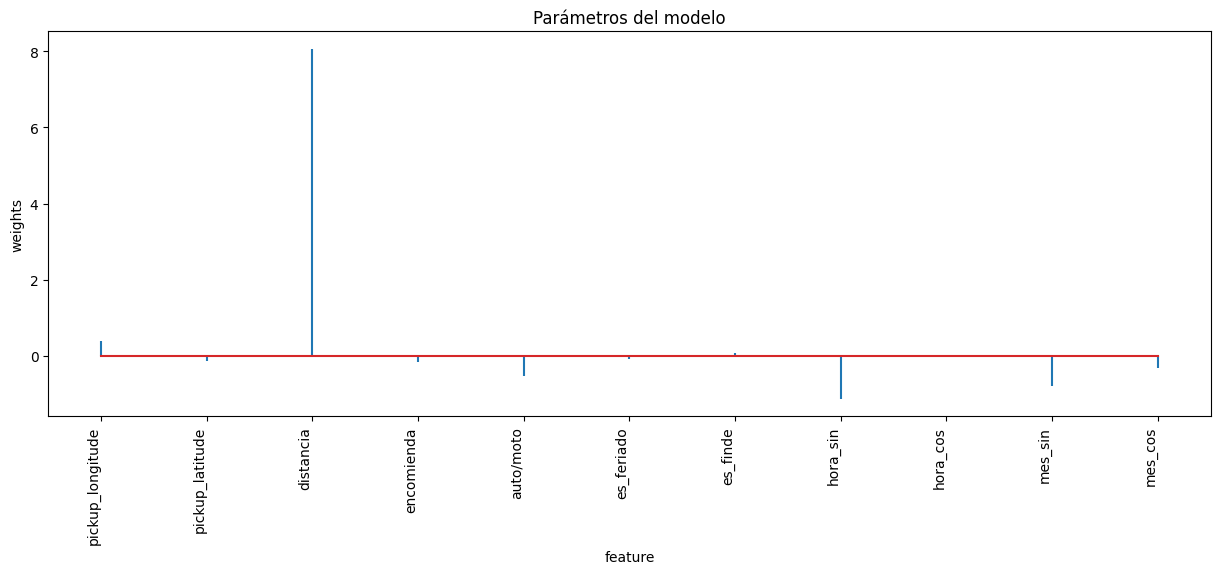

In [50]:
df_coeficientes = pd.DataFrame({'predictor': X_train.columns,'coef': mod.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

Predicciones

In [51]:
# Predicciones test
y_pred = pipe.predict(X_test)
y_pred.shape, y_test.shape

((39102,), (39102,))

Error del modelo

In [52]:
rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"El error (rmse) de train es: {rmse_ridge_train}")
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de train es: 4.674455391920723
El error (rmse) de test es: 4.6222602731449465


In [53]:
# R^2 en el conjunto de entrenamiento
r2_train_ridge = pipe.score(X_train, y_train)
print(f"R^2 en train: {r2_train:.4f}")

# R^2 en el conjunto de prueba
r2_test_ridge = pipe.score(X_test, y_test)

print(f"R^2 en test: {r2_test:.4f}")

R^2 en train: 0.7571
R^2 en test: 0.7687


### Lasso

Creación del modelo de Lasso y fitteo

In [54]:
modelo_lasso = LassoCV(
            alphas          = np.logspace(-6, 2, 200),
            cv              = 10
         )
_ = modelo_lasso.fit(X = X_train_scaled, y = y_train.values)

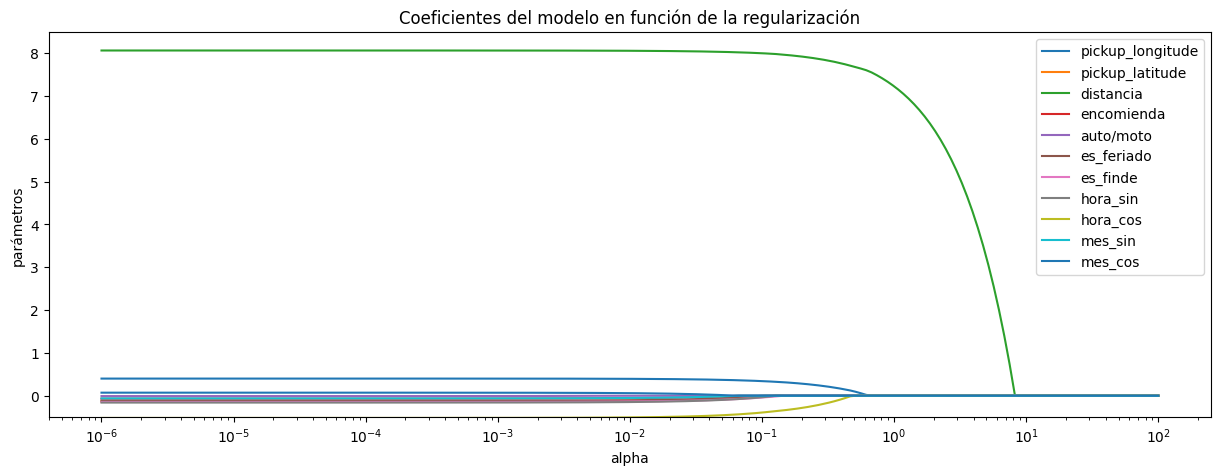

In [55]:
alphas = modelo_lasso.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.named_steps['lasso'].coef_.flatten())
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()


Puede ver se como, a medida que aumenta el valor de alpha, la regularización es mayor y más predictores quedan excluidos (su coeficiente es 0).

Text(0.5, 1.0, 'Features incluidas en función de la regularización')

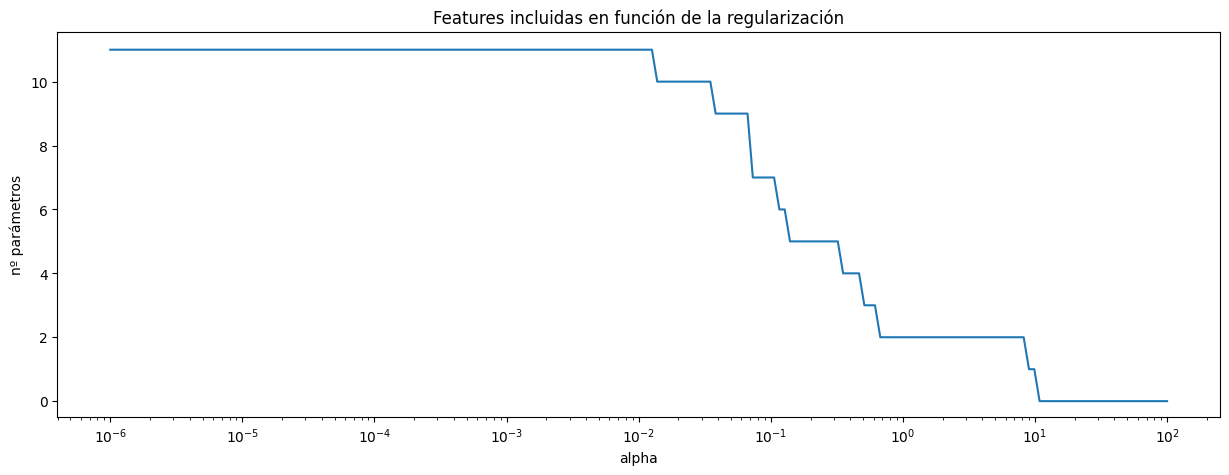

In [56]:
# Número de features incluidas (parámetros !=0) en función de alpha
alphas = modelo_lasso.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train_scaled, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')

Evolución del error de validación cruzada en función de alpha

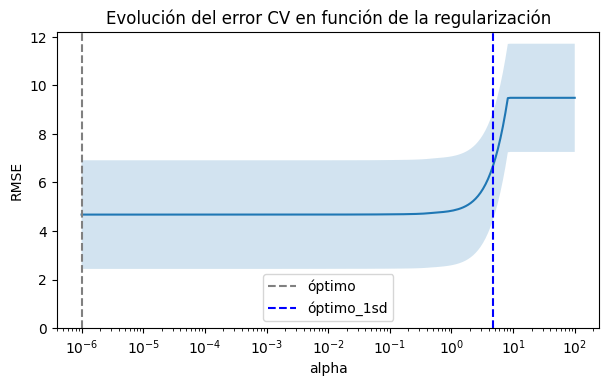

In [57]:
mse_cv = modelo_lasso.mse_path_.mean(axis=1)
mse_sd = modelo_lasso.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo_lasso.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo_lasso.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo_lasso.alphas_, rmse_cv)
ax.fill_between(
    modelo_lasso.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()

In [58]:
print(f"Mejor valor de alpha encontrado: {modelo_lasso.alpha_}")

Mejor valor de alpha encontrado: 1e-06


In [59]:
# Mejor valor alpha encontrado + 1sd

min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo_lasso.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo_lasso.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [4.71375313]


In [60]:
# Mejor modelo alpha óptimo + 1sd

modelo_lasso = Lasso(alpha=optimo_1sd[0])
modelo_lasso.fit(X = X_train_scaled, y = y_train.values)

Lasso(alpha=np.float64(4.713753134116729))

In [61]:
# Reentreno con alpha = 0.03

modelo_lasso = Lasso(alpha=0.03)
modelo_lasso.fit(X = X_train_scaled, y = y_train.values)

Lasso(alpha=0.03)

Coeficientes del modelo

In [62]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_lasso.coef_.flatten()}
                  )

df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,pickup_longitude,0.382844
1,pickup_latitude,-0.096563
2,distancia,8.038008
6,es_finde,-0.158470
7,hora_sin,-0.123114
8,hora_cos,-0.485094
9,mes_sin,-0.032450
10,mes_cos,0.028568


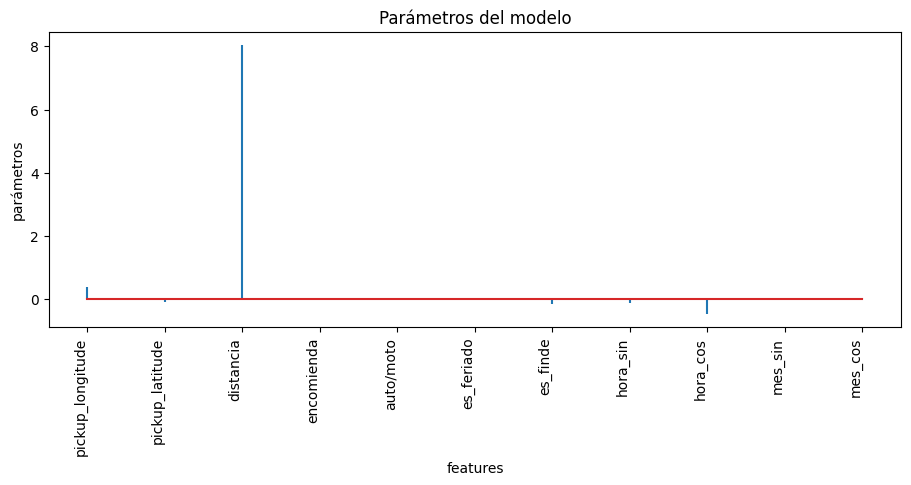

In [63]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

Predicciones

In [64]:
# Predicciones para train y test
predicciones_lasso_train = modelo_lasso.predict(X_train_scaled)
predicciones_lasso_test = modelo_lasso.predict(X_test_scaled)

Error del modelo

In [65]:
rmse_lasso_train = np.sqrt(mean_squared_error(y_train, predicciones_lasso_train))
rmse_lasso_test = np.sqrt(mean_squared_error(y_test, predicciones_lasso_test))
print(f"El error (rmse) de train es: {rmse_lasso_train:.3f}")
print(f"El error (rmse) de test es: {rmse_lasso_test:.3f}")

El error (rmse) de train es: 4.678
El error (rmse) de test es: 4.626


In [66]:
# R² para entrenamiento
R2_train_lasso = metrics.r2_score(y_train, predicciones_lasso_train)
# R² para test
R2_test_lasso = metrics.r2_score(y_test, predicciones_lasso_test)

print(f"R² (train): {R2_train_lasso:.3f}")
print(f"R² (test): {R2_test_lasso:.3f}")

R² (train): 0.757
R² (test): 0.768


### Elasticnet

Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)

In [67]:
# Por defecto ElasticNetCV utiliza el mean squared error
modelo_elastic = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )
_ = modelo_elastic.fit(X = X_train_scaled, y = y_train.values)

Evolución del error en función de alpha y l1_ratio

In [68]:
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = modelo_elastic.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo_elastic.l1_ratio, modelo_elastic.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
108,0.0,0.000088,21.857753,4.675228
109,0.0,0.000076,21.857753,4.675228
110,0.0,0.000065,21.857753,4.675228
107,0.0,0.000102,21.857753,4.675228
111,0.0,0.000056,21.857753,4.675228
...,...,...,...,...
625,0.7,23.272025,89.947208,9.484050
626,0.7,20.022004,89.947208,9.484050
627,0.7,17.225860,89.947208,9.484050
628,0.7,14.820207,89.947208,9.484050


Mejor valor encontrado para cada l1_ratio

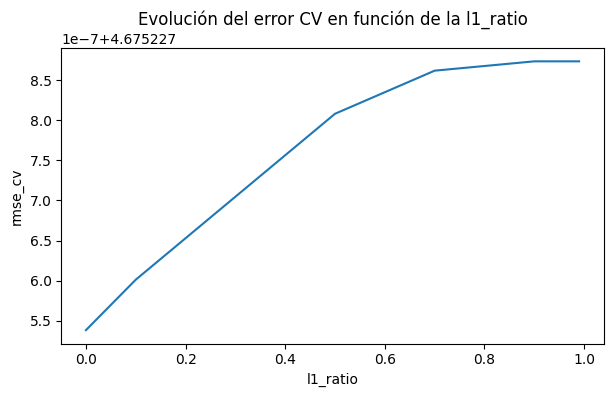

In [69]:
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

Mejor valor alpha y l1_ratio_ encontrado


In [70]:
print(f"Mejor valor de alpha encontrado: {modelo_elastic.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo_elastic.l1_ratio_}")

Mejor valor de alpha encontrado: 8.804883581643464e-05
Mejor valor de l1_ratio encontrado: 0.0


Coeficientes del modelo

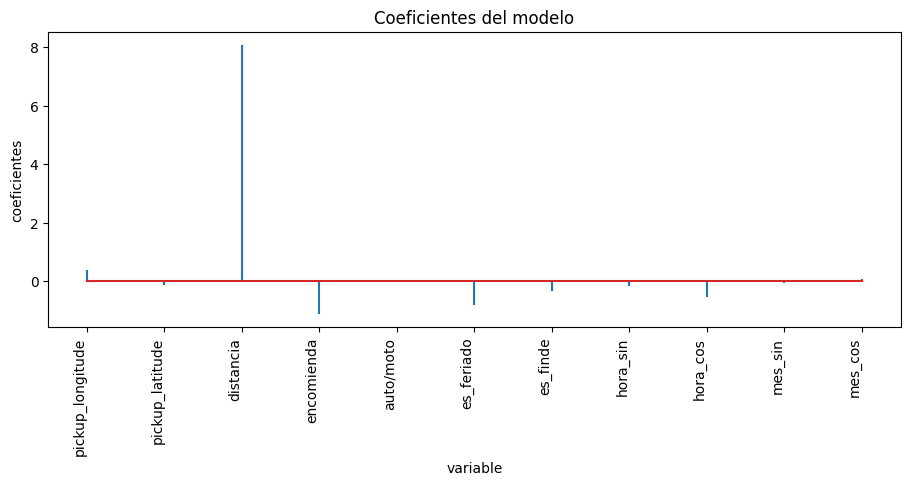

In [71]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_elastic.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

Predicciones

In [72]:
predicciones_train_elastic = modelo_elastic.predict(X=X_train_scaled)
predicciones_test_elastic = modelo_elastic.predict(X=X_test_scaled)

Error del modelo

In [73]:
rmse_train_elastic = np.sqrt(mean_squared_error(y_train, predicciones_train_elastic))
rmse_test_elastic = np.sqrt(mean_squared_error(y_test, predicciones_test_elastic))
print(f"El error (rmse) de train es: {rmse_train_elastic}")
print(f"El error (rmse) de test es: {rmse_test_elastic}")

El error (rmse) de train es: 4.674455783480048
El error (rmse) de test es: 4.622261159222778


In [74]:
# R² para entrenamiento
R2_train_elast = metrics.r2_score(y_train, predicciones_train_elastic)
# R² para test
R2_test_elast = metrics.r2_score(y_test, predicciones_test_elastic)

print(f"R² (train): {R2_train_elast:.3f}")
print(f"R² (test): {R2_test_elast:.3f}")

R² (train): 0.757
R² (test): 0.769


## Gradiente descendiente

Primero hacemos una subdivisión de los datos de entrenamiento en entrenamiento y validación.

In [75]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [76]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [77]:
# Convertir a numpy arrays con la forma correcta
X_train_final = X_train_final.values
X_val = X_val.values
y_train_final = y_train_final.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

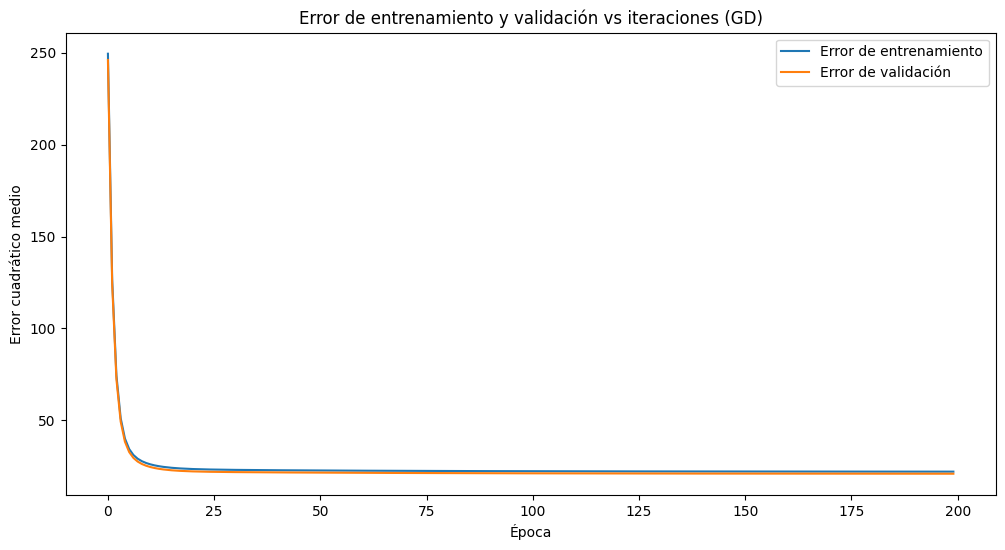

In [78]:
W_gd = gradient_descent(X_train_final, y_train_final, X_val, y_val, lr=0.1, epochs=200)
X_test_gd = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled.values))
y_pred_gd = np.matmul(X_test_gd, W_gd)

El error disminuye rápido al principio.
Luego se estabiliza, tanto en entrenamiento como en validación.
No hay overfitting visible: ambas curvas son muy similares y descienden parejo.
El algoritmo está convergiendo.

In [79]:
# Asegurarse de que y_test y y_pred_gd tengan la misma forma
y_test_array = y_test.values.reshape(-1, 1)  # si y_test es un DataFrame o Serie

Error del modelo

In [80]:
# Calcular RMSE
rmse_test_gd = np.sqrt(mean_squared_error(y_test_array, y_pred_gd))

# Calcular R²
r2_test_gd = r2_score(y_test_array, y_pred_gd)

# Mostrar resultados
print(f"Resultados del modelo con Gradiente Descendente (Batch GD):")
print(f"RMSE test: {rmse_test_gd:.4f}")
print(f"R² test: {r2_test_gd:.4f}")


Resultados del modelo con Gradiente Descendente (Batch GD):
RMSE test: 4.6302
R² test: 0.7679


In [81]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=32):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Convertir a numpy si vienen como Series
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.to_numpy().reshape(-1, 1)

    # Agregar columna de bias
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Inicializar pesos
    W = np.random.randn(m + 1).reshape(-1, 1)

    # Listas para guardar los errores de cada época
    train_errors = []
    test_errors = []

    for epoch in range(epochs):
        # Mezclar los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        # Entrenamiento por mini-batches
        for j in range(0, n, batch_size):
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size
            W = W - (lr * gradient)

        # Calcular errores al final de cada época
        train_pred = np.matmul(X_train, W)
        train_error = y_train.reshape(-1, 1) - train_pred
        train_mse = np.mean(train_error ** 2)
        train_errors.append(train_mse)

        test_pred = np.matmul(X_test, W)
        test_error = y_test.reshape(-1, 1) - test_pred
        test_mse = np.mean(test_error ** 2)
        test_errors.append(test_mse)

    # Graficar errores
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.title('Error de entrenamiento y prueba vs épocas (Mini-Batch GD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return W


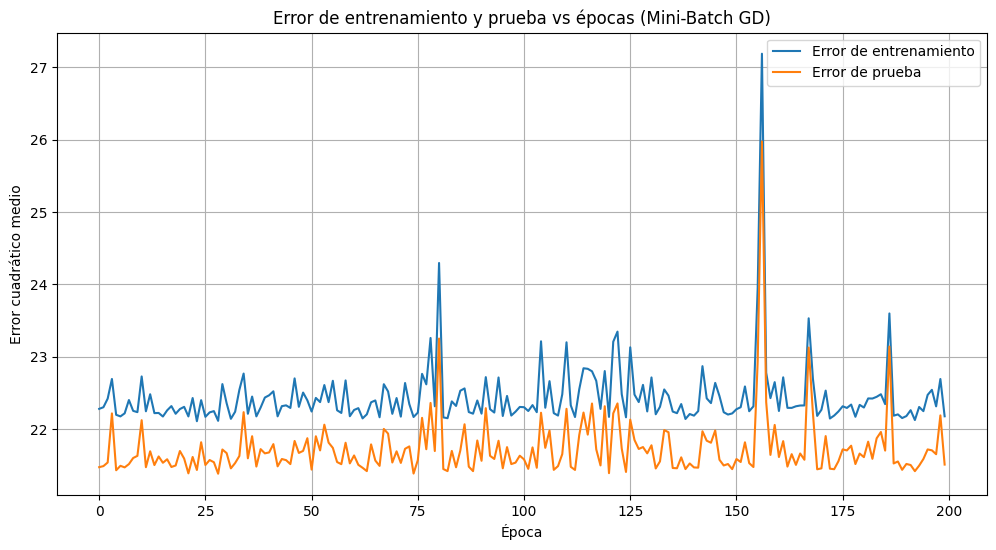

In [82]:
W_mb = mini_batch_gradient_descent(X_train_final, y_train_final, X_test_scaled, y_test, lr=0.01, epochs=200, batch_size=11)
X_test_mb = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled.values))
y_pred_mb = np.matmul(X_test_mb, W_mb)

Error del modelo

In [83]:
# Asegurarse de que y_test y y_pred_gd tengan la misma forma
y_test_array = y_test.values.reshape(-1, 1)  # si y_test es un DataFrame o Serie

# Calcular RMSE
rmse_test_mb = np.sqrt(mean_squared_error(y_test_array, y_pred_mb))

# Calcular R²
r2_test_mb = r2_score(y_test_array, y_pred_gd)

# Mostrar resultados
print(f"Resultados del modelo con Gradiente Descendente Mini Batch (Mini Batch GD):")
print(f"RMSE test: {rmse_test_mb:.4f}")
print(f"R² test: {r2_test_mb:.4f}")

Resultados del modelo con Gradiente Descendente Mini Batch (Mini Batch GD):
RMSE test: 4.6379
R² test: 0.7679


# Comparacion de modelos

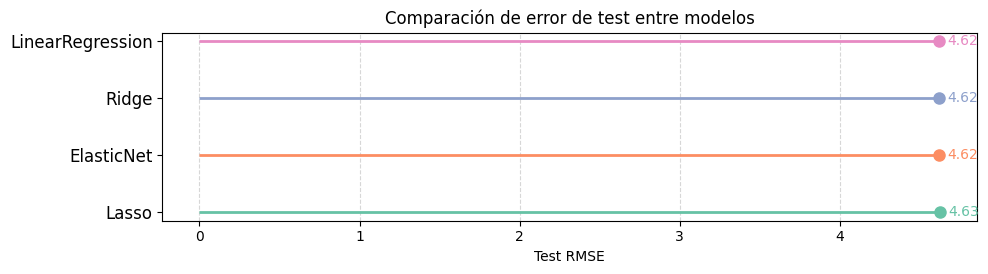

In [84]:
colores = sns.color_palette("Set2", n_colors=4)
error_modelos = pd.DataFrame({
    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet'],
    'rmse': [rmse_test, rmse_ridge, rmse_lasso_test, rmse_test_elastic]
})
error_modelos = error_modelos.sort_values('rmse', ascending=False).reset_index(drop=True)

#Gráfico
fig, ax = plt.subplots(figsize=(10, 2.84))

for i, (modelo, rmse) in enumerate(zip(error_modelos.modelo, error_modelos.rmse)):
    color = colores[i]
    ax.hlines(modelo, xmin=0, xmax=rmse, color=color, linewidth=2)
    ax.plot(rmse, modelo, "o", color=color, markersize=8)
    ax.text(rmse + 0.05, modelo, f"{rmse:.2f}", va='center', fontsize=10, color=color)

ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title('Comparación de error de test entre modelos')
ax.set_xlabel('Test RMSE')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


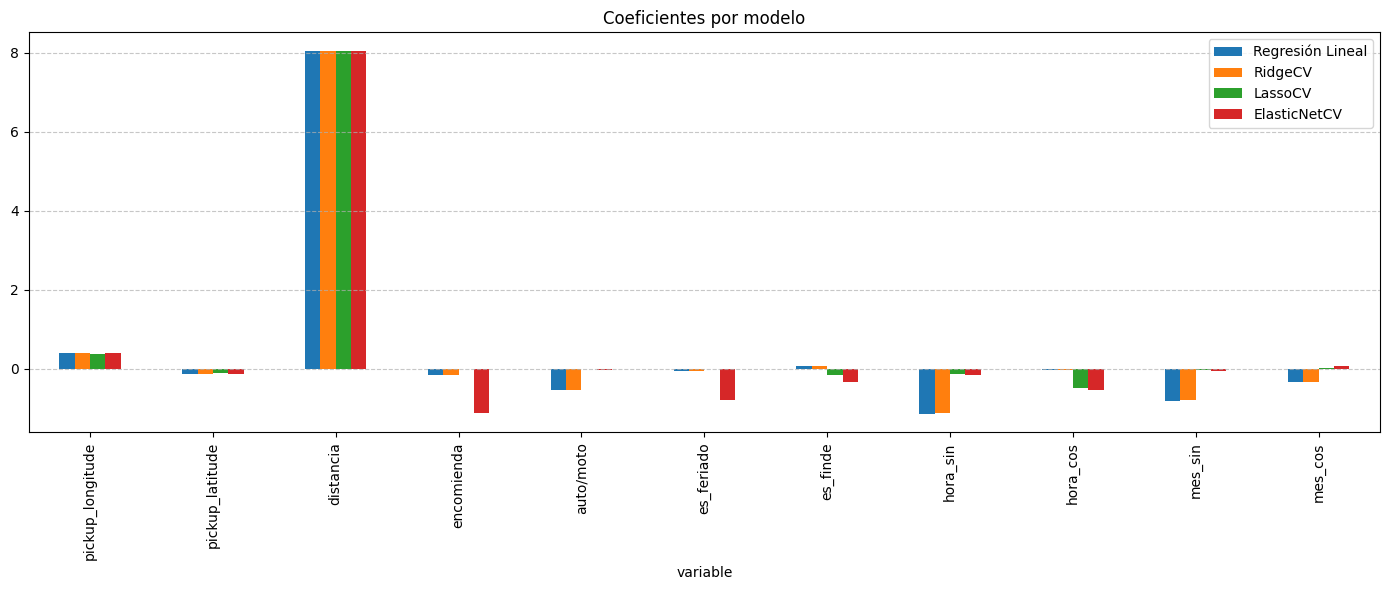

In [85]:
df_coef = pd.DataFrame({
    'variable': X_train.columns,
    'Regresión Lineal': pipeline.named_steps['modelo'].coef_,
    'RidgeCV': pipe.named_steps['modelo'].coef_,
    'LassoCV': modelo_lasso.coef_,
    'ElasticNetCV': modelo_elastic.coef_
})

df_coef.set_index('variable').plot(kind='bar', figsize=(14, 6), title="Coeficientes por modelo")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Líneas horizontales punteadas
plt.tight_layout()
plt.show()


El modelo con regularización Lasso tiene un error ligeramente superior al modelo OLS pero emplea solo 1 predictor en lugar de 11

In [86]:
# Creamos un diccionario con los resultados
resultados_modelos = {
    'Modelo': [
        'Regresión Lineal',
        'Ridge',
        'Lasso',
        'Elastic Net',
        'Batch Gradient Descent',
        'Mini-Batch Gradient Descent'
    ],
    'RMSE Train': [
        rmse_train,  # reemplazar con tus valores
        rmse_ridge_train,
        rmse_lasso_train,
        rmse_train_elastic,
        'N/A',
        'N/A'
    ],
    'RMSE Test': [
        rmse_test,
        rmse_ridge,
        rmse_lasso_test,
        rmse_test_elastic,
        rmse_test_gd,
        rmse_test_mb
    ],
    'R² Train': [
        r2_train,
        r2_train_ridge,
        R2_test_lasso,
        R2_train_elast,
        'N/A',
        'N/A'
    ],
    'R² Test': [
        r2_test,
        r2_test_ridge,
        R2_test_lasso,
        R2_test_elast,
        r2_test_gd,
        r2_test_mb
    ]
}

# Convertimos el diccionario en DataFrame
df_resultados = pd.DataFrame(resultados_modelos)

# Mostramos la tabla ordenada
df_resultados = df_resultados.sort_values(by='RMSE Test')
display(df_resultados)

,Modelo,RMSE Train,RMSE Test,R² Train,R² Test
0,Regresión Lineal,4.674455,4.622258,0.757066,0.768654
1,Ridge,4.674455,4.622260,0.757066,0.768654
3,Elastic Net,4.674456,4.622261,0.757066,0.768654
2,Lasso,4.677545,4.626013,0.768278,0.768278
4,Batch Gradient Descent,N/A,4.630181,N/A,0.767860
5,Mini-Batch Gradient Descent,N/A,4.637905,N/A,0.767860


# Conclusión

En el desarrollo del trabajo implementamos, evaluamos y comparamos modelos de regresión lineal que permitan predecir el costo de los viajes de Uber. Los métodos utilizados fueron LinearRegression, gradiente descendiente (Batch Gradient Descent y Mini-Batch Gradient Descent) y regularización: Lasso, Ridge, Elastic Net.


Los resultados obtenidos mostraron que los modelos poseen métricas muy similares, tanto de RMSE como R², y se pudo observar poca variación entre dichas métricas aplicadas a los datos de entrenamiento y de prueba.

Del análisis de la selección de variables del modelo y de los coeficientes del mismo podemos concluir que hay una influencia fuerte de la variable explicativa 'distancia' en la variable target.

Los métodos de regularización, de ajuste de hiperparámetros y de optimización no tienen un impacto significativo en comparación con los resultados del modelo de regresión lineal, lo que sugiere que un modelo lineal simple predice los datos de manera correcta. El hecho de que no se produzcan mejoras con los métodos de regularización puede deberse a que las features no estan altamente correlacionadas y que los datos que utiliza el modelo no poseen un ruido excesivo.

Dado que las métricas de error apenas varían entre entrenamiento y prueba, se descarta la presencia de overfitting. Además, con valores de R² cercanos a 0.76 en todos los modelos, podemos concluir que el ajuste es bueno, aunque podría mejorarse incluyendo nuevas variables explicativas para capturar mayor variabilidad en el costo de los viajes.

En futuras investigaciones, podría considerarse la inclusión de variables adicionales en el registro de datos, como lo son las condiciones climáticas, si el viaje fue cancelado, eventos especiales cercanos a las coordenadas de origen.


# Bibliografia

https://scikit-learn.org/stable/supervised_learning.html

https://scikit-learn.org/stable/modules/linear_model.html

https://cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html

Machine learning con Python y Scikit-learn por Joaquín Amat Rodrigo, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html

Regularización Ridge, Lasso y Elastic Net con Python por Joaquín Amat Rodrigo, disponible con licencia CC BY-NC-SA 4.0 en https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html

